In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

np.random.seed(1)
from data_utils import import_data, preprocessing
from evaluation import show_pred_info, create_ground_truth, fix_dates, convert_dates
from config_paths import PATHS, AUX_PATHS

In [3]:
df_dict = {}
for name in PATHS.keys():
    df_dict[name] = import_data(name, paths=PATHS, aux_paths=AUX_PATHS).pipe(
        preprocessing, name=name, filter_id=4
    )
    print("------------------------------------------------------")


ground_truth = create_ground_truth(
    AUX_PATHS, cols_to_keep=["ID", "IDpix", "Finicio", "Ffinal"]
)
ground_truth = ground_truth.pipe(fix_dates).pipe(convert_dates)

Importing 1895 timestamps and 2309 Time Series for ESTABLE.
Preprocessed data for ESTABLE. 2309 TimeSeries and 1195 TimeStamps.
------------------------------------------------------
Importing 2131 timestamps and 9270 Time Series for INCENDIO.
Preprocessed data for INCENDIO. 9270 TimeSeries and 1195 TimeStamps.
------------------------------------------------------
Importing 2370 timestamps and 6666 Time Series for SEQUIA.
Preprocessed data for SEQUIA. 6666 TimeSeries and 1195 TimeStamps.
------------------------------------------------------
Importing 1801 timestamps and 6411 Time Series for TALA.
Preprocessed data for TALA. 6411 TimeSeries and 1195 TimeStamps.
------------------------------------------------------
Importing 1689 timestamps and 2441 Time Series for VARIOS.
Preprocessed data for VARIOS. 2441 TimeSeries and 1195 TimeStamps.
------------------------------------------------------


In [4]:
anomalies_df = pd.read_parquet("../data/predictions/DeepAnt_preds.parquet")
correct_anomalies = anomalies_df.query("NAME != 'ESTABLE' and is_right")
incorrect_anomalies = anomalies_df.query("NAME == 'ESTABLE'")
total = anomalies_df.shape[0]
n_correct = correct_anomalies.shape[0]
n_incorrect = incorrect_anomalies.shape[0]
print("=========================================================")
print(f"Total number of Anomalies Detected: {total:,}")
print(f"Number of Correct Anomalies Detected: {n_correct:,}")
print(f"Number of Incorrect Anomalies Detected: {n_incorrect:,}")
print(f"Other Anomalies Detected: {total-n_correct-n_incorrect:,}")
anomalies_df

Total number of Anomalies Detected: 202,575
Number of Correct Anomalies Detected: 76,201
Number of Incorrect Anomalies Detected: 26,446
Other Anomalies Detected: 99,928


,target_indices,target_dates,NAME,IDpix,ID,Finicio,Ffinal,is_right,P_id
0,ESTABLE-221-6,2016-03-13,ESTABLE,221,6,2004-12-17,2022-05-01,True,ESTABLE-6
1,ESTABLE-222-6,2016-03-13,ESTABLE,222,6,2004-12-17,2022-05-01,True,ESTABLE-6
2,ESTABLE-223-6,2016-03-13,ESTABLE,223,6,2004-12-17,2022-05-01,True,ESTABLE-6
3,ESTABLE-224-6,2016-03-13,ESTABLE,224,6,2004-12-17,2022-05-01,True,ESTABLE-6
4,ESTABLE-225-6,2016-03-13,ESTABLE,225,6,2004-12-17,2022-05-01,True,ESTABLE-6
...,...,...,...,...,...,...,...,...,...
202570,VARIOS-632-337,2022-11-06,VARIOS,632,337,2017-08-13,2018-02-20,False,VARIOS-337
202571,VARIOS-633-337,2022-11-06,VARIOS,633,337,2017-08-13,2018-02-20,False,VARIOS-337
202572,VARIOS-571-337,2022-11-13,VARIOS,571,337,2017-08-13,2018-02-20,False,VARIOS-337
202573,VARIOS-573-337,2022-11-13,VARIOS,573,337,2017-08-13,2018-02-20,False,VARIOS-337


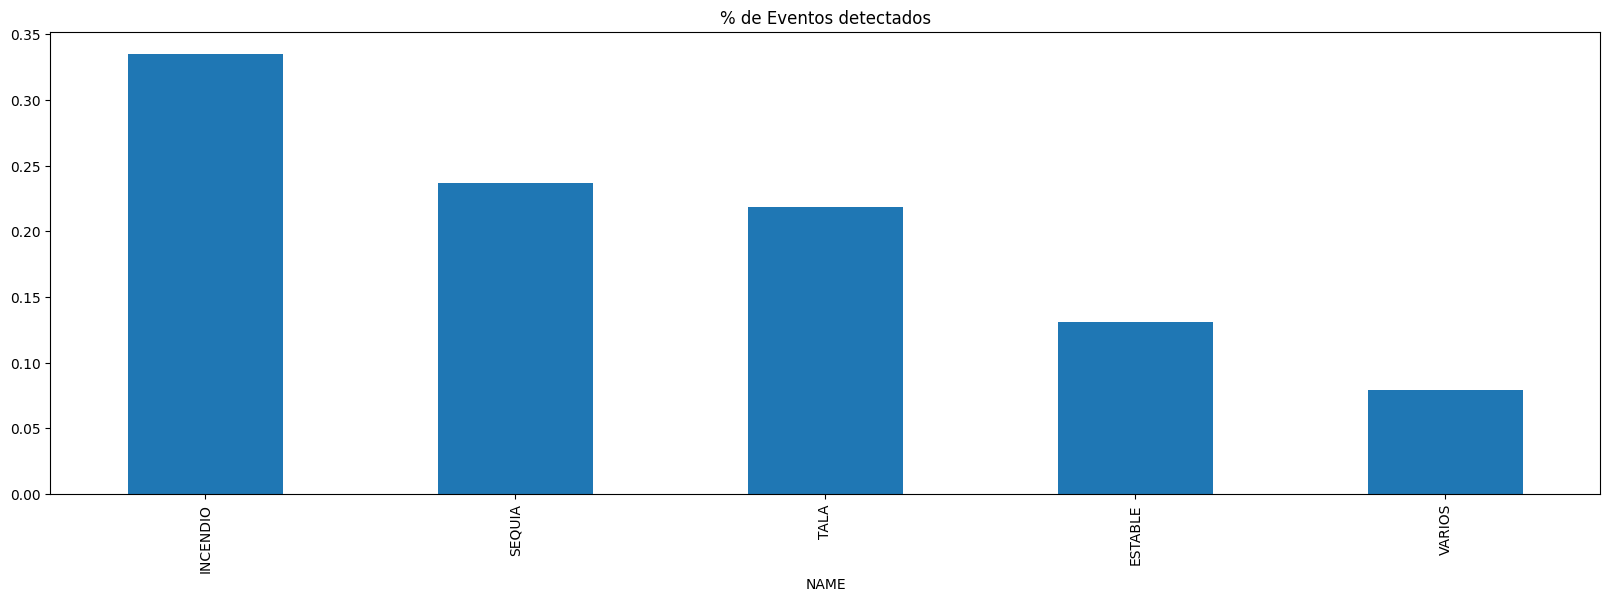

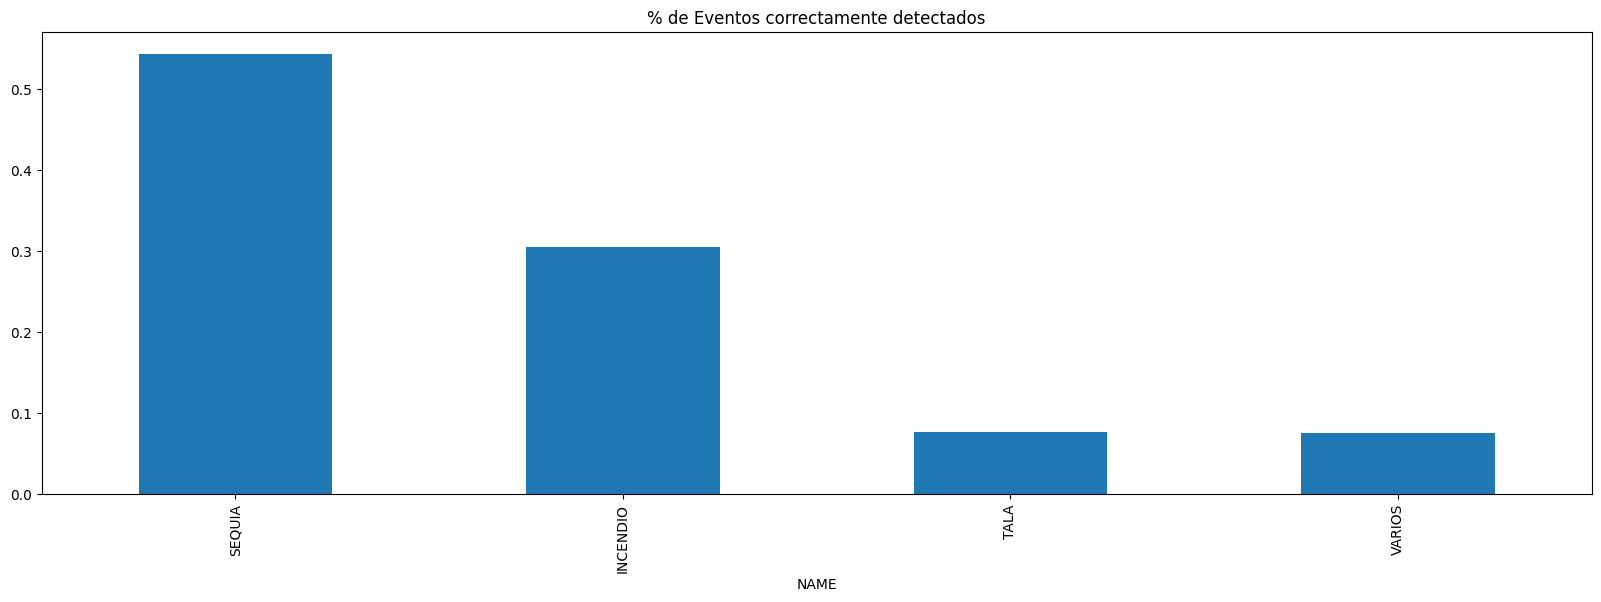

In [41]:
import matplotlib.pyplot as plt


def plot_events_detected(df, title=""):
    df.NAME.value_counts(normalize=True).plot(figsize=(20, 6), kind="bar", title=title)
    plt.show()


plot_events_detected(anomalies_df, title="% de Eventos detectados")
plot_events_detected(
    anomalies_df.query("NAME != 'ESTABLE' and is_right"),
    title="% de Eventos correctamente detectados",
)

Número de Polígonos detectados: 194
Número de Polígonos totales: 344


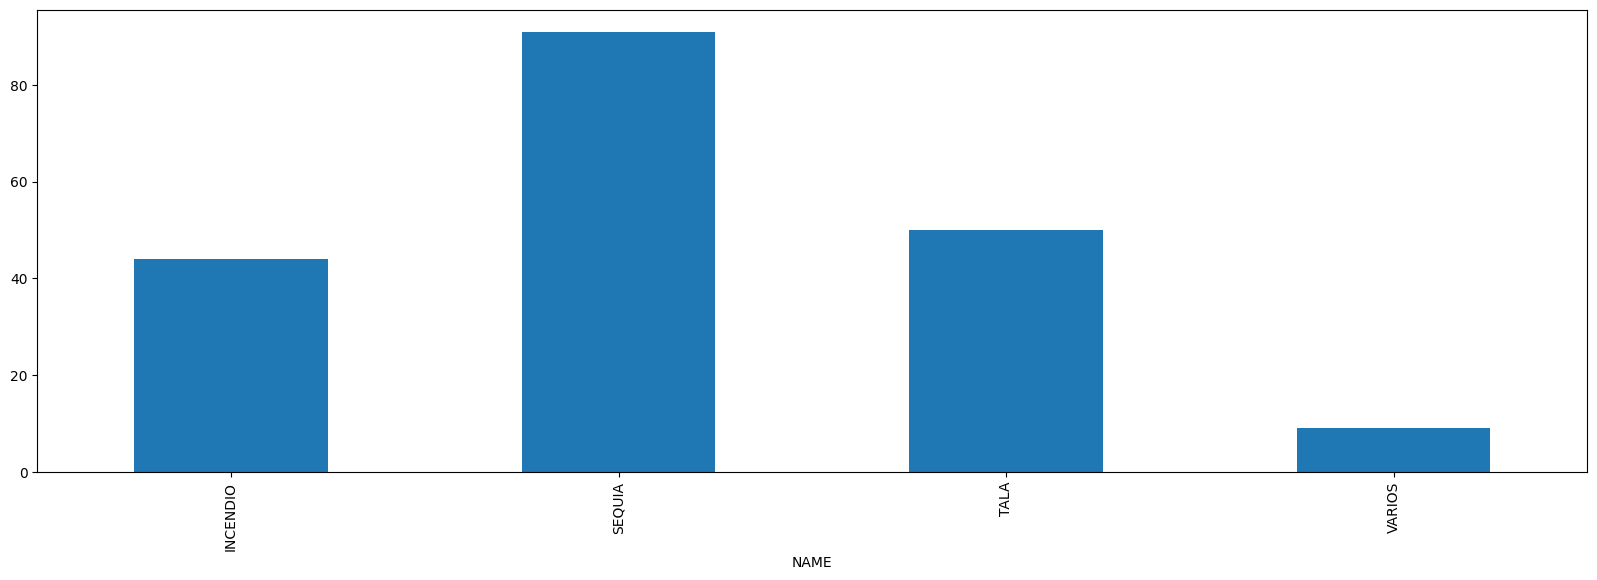

In [6]:
total_polygons_detected = (
    correct_anomalies.groupby(["NAME", "ID"], as_index=False)
    .size()
    .groupby("NAME")
    .size()
)
total_polygons_detected.plot(kind="bar", figsize=(20, 6))

total_polygons = ground_truth.query("NAME != 'ESTABLE'").ID.nunique()
print(f"Número de Polígonos detectados: {total_polygons_detected.sum()}")
print(f"Número de Polígonos totales: {total_polygons}")

# Métricas

In [7]:
from data_prep import split_idx

DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24',
               '2016-01-31', '2016-02-07', '2016-02-14', '2016-02-21',
               '2016-02-28', '2016-03-06',
               ...
               '2022-10-23', '2022-10-30', '2022-11-06', '2022-11-13',
               '2022-11-20', '2022-11-27', '2022-12-04', '2022-12-11',
               '2022-12-18', '2022-12-25'],
              dtype='datetime64[ns]', length=365, freq='W-SUN')

In [42]:
_, test_indices = split_idx(df_dict, date="2016-01-01")
preds_idx = anomalies_df.query("NAME != 'ESTABLE' and not is_right").drop_duplicates(
    subset="target_indices"
)
preds_idx

data = (
    ground_truth.merge(preds_idx, how="outer", indicator=True)
    .query("_merge == 'left_only' and NAME != 'ESTABLE'")
    .drop(columns="_merge")[["Finicio", "Ffinal"]]
    .to_numpy()
)
fn_points = []
for idx, (finicio, ffinal) in enumerate(data):
    fn_points.append(((finicio < test_indices) & (test_indices < ffinal)).sum())
fn = sum(fn_points)
fn

1808792

In [40]:
tp = anomalies_df.query("NAME != 'ESTABLE' and is_right").shape[0]
fp = anomalies_df.query("NAME == 'ESTABLE'").shape[0]
precision = tp / (tp + fp)  # precision
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Precision: 0.7423597377419701
Recall: 0.04042508380667727
F1: 0.07667485057656316


min    0.002257
max    1.000000
Name: perc, dtype: float64

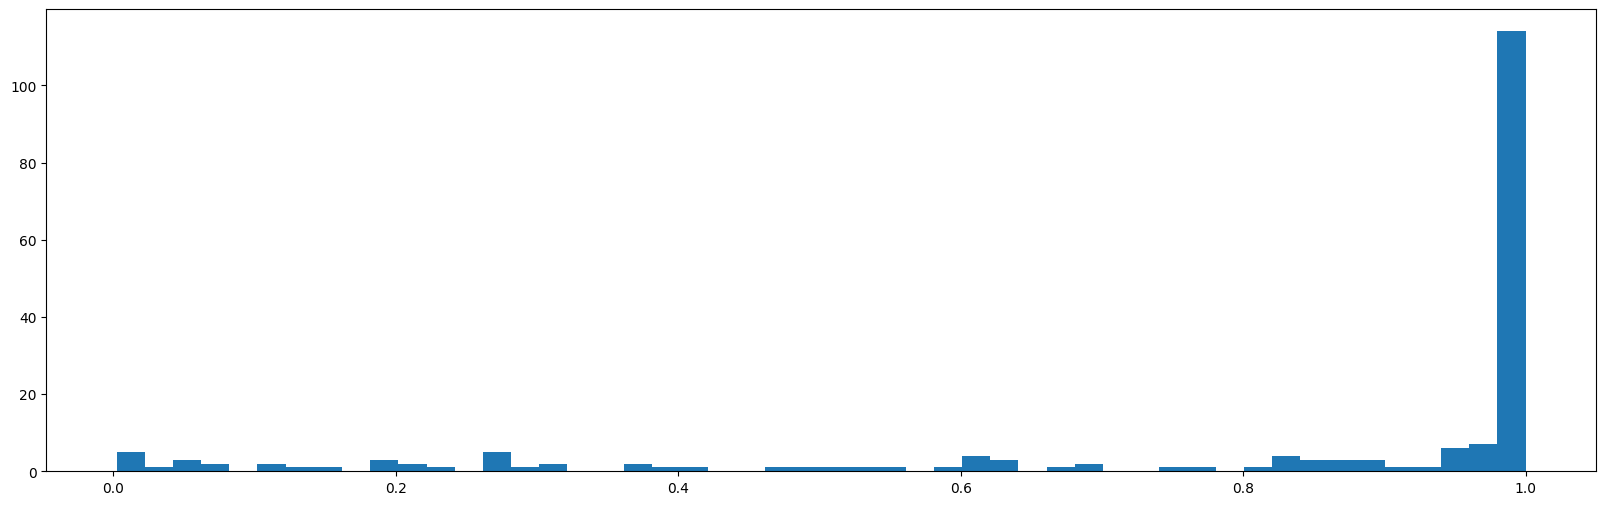

In [ ]:
total = ground_truth.groupby(["ID"]).size()
total.name = "pix_total"

resultados = (
    correct_anomalies.drop_duplicates(subset=["target_indices"])
    .groupby("ID")
    .size()
    .to_frame()
    .join(total)
    .assign(perc=lambda x: x[0] / x["pix_total"])
)
plt.figure(figsize=(20, 6))
plt.hist(resultados["perc"], bins=50)
resultados["perc"].agg(["min", "max"])

# Ejemplos

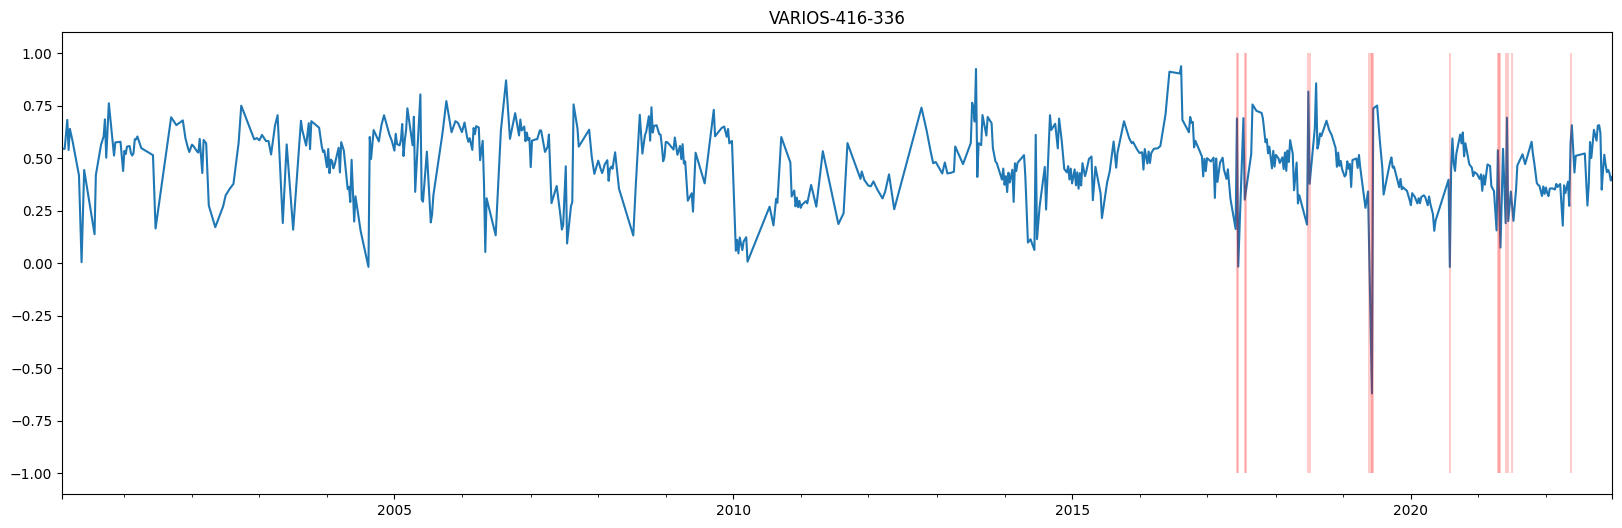

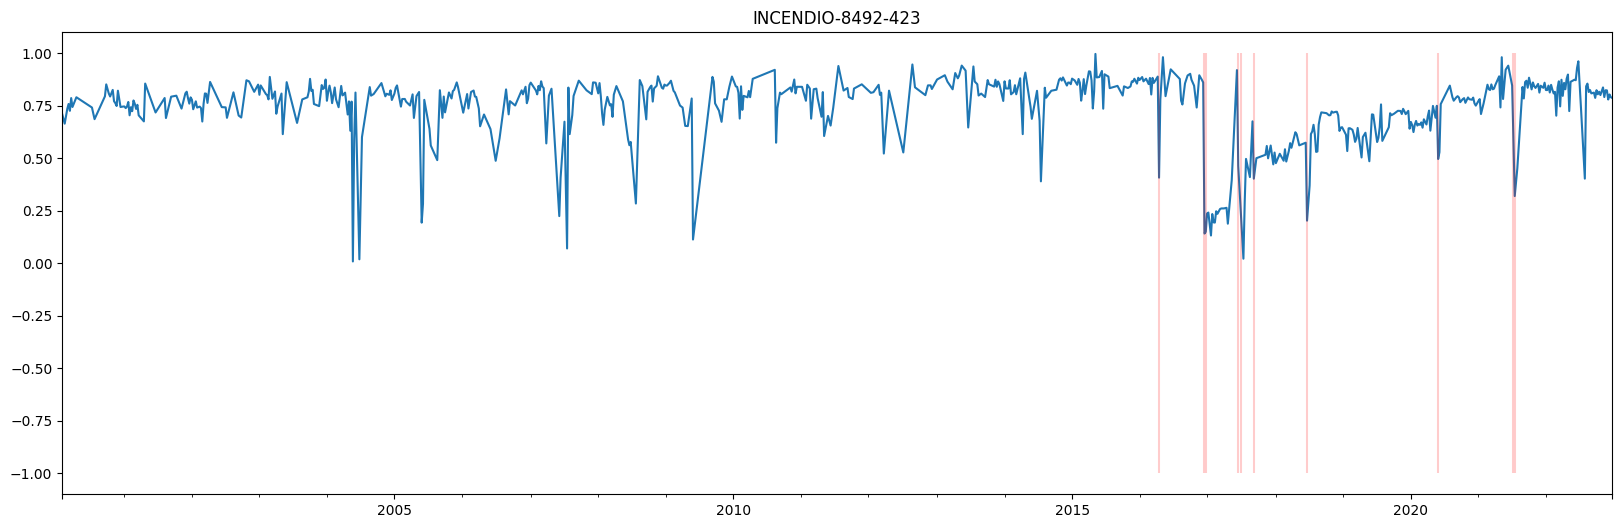

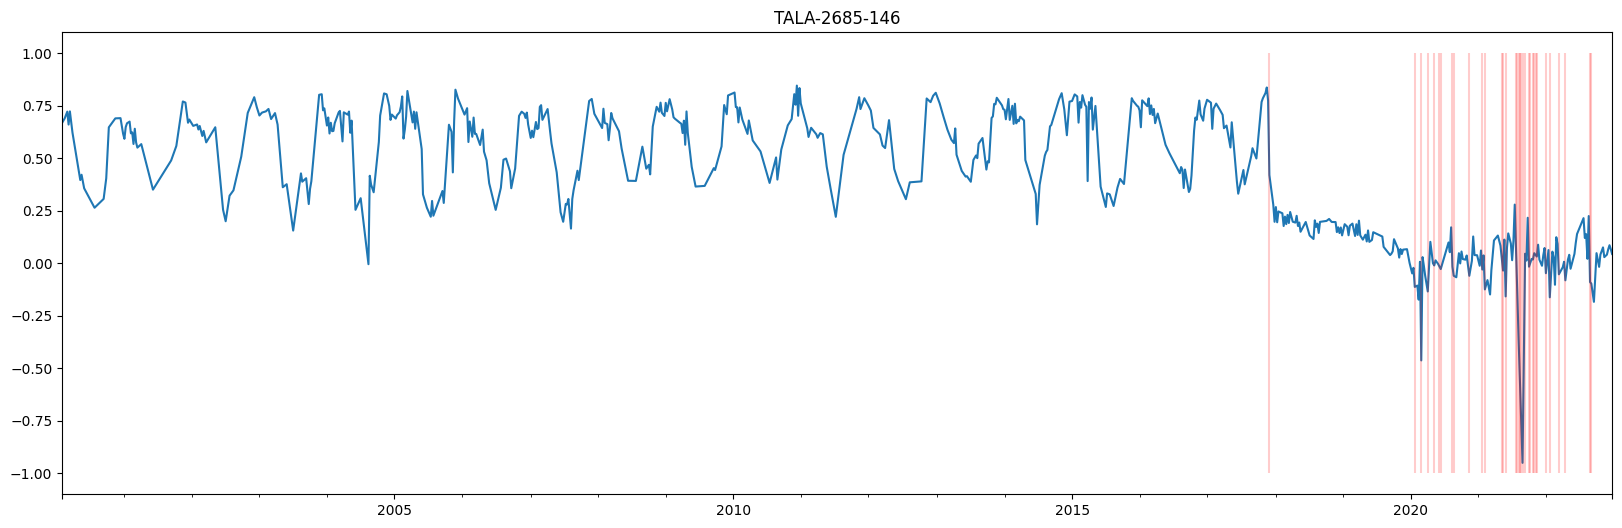

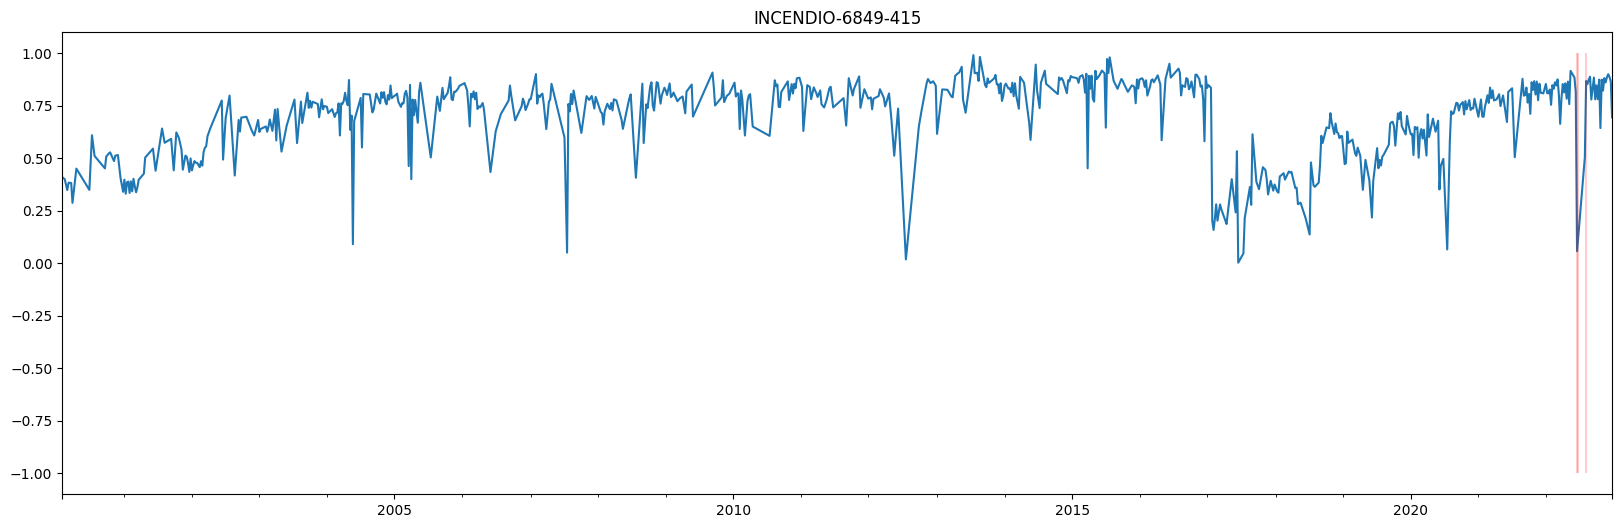

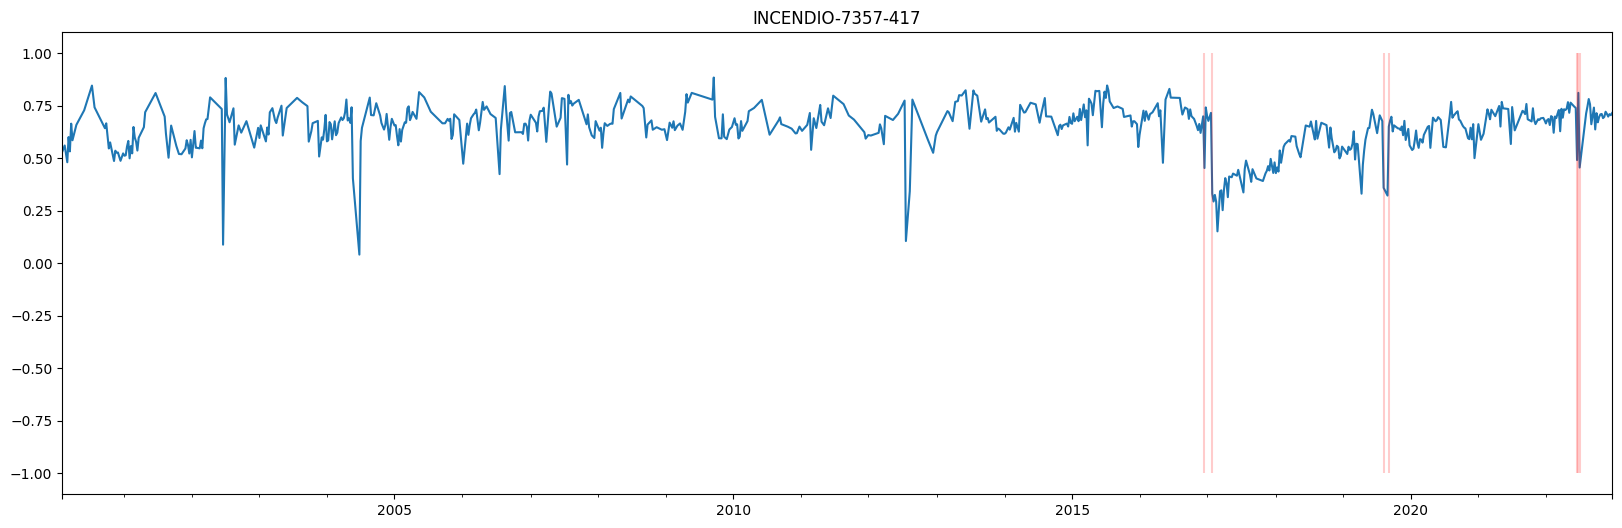

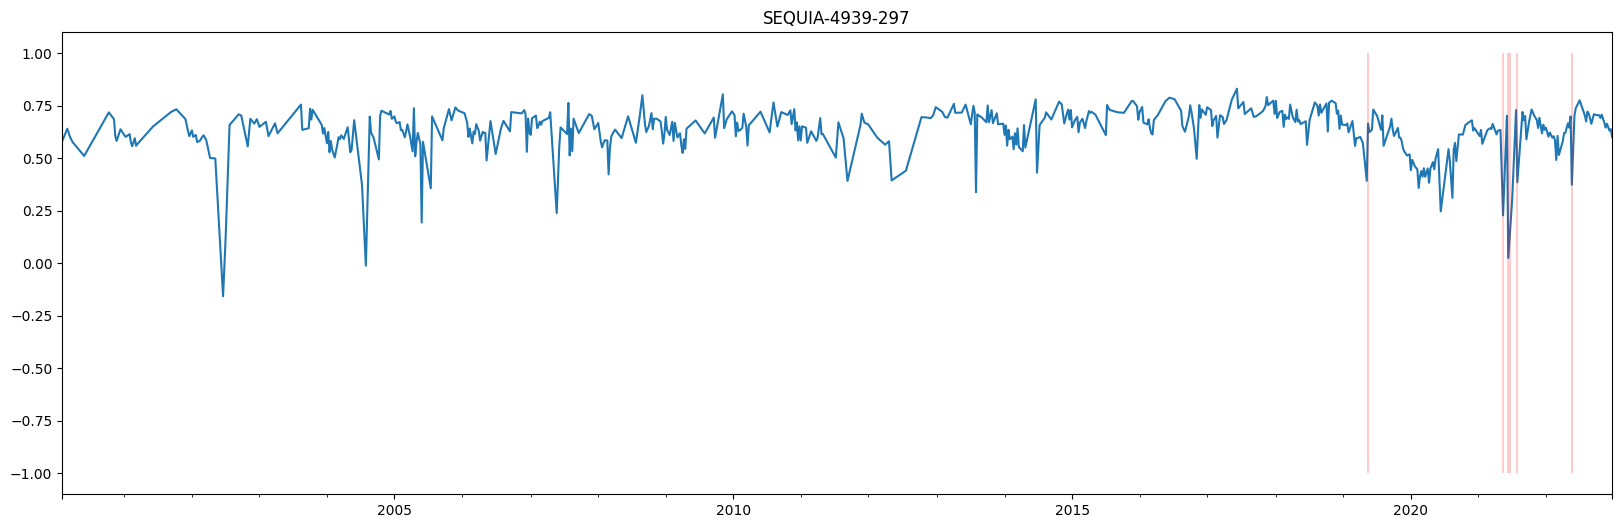

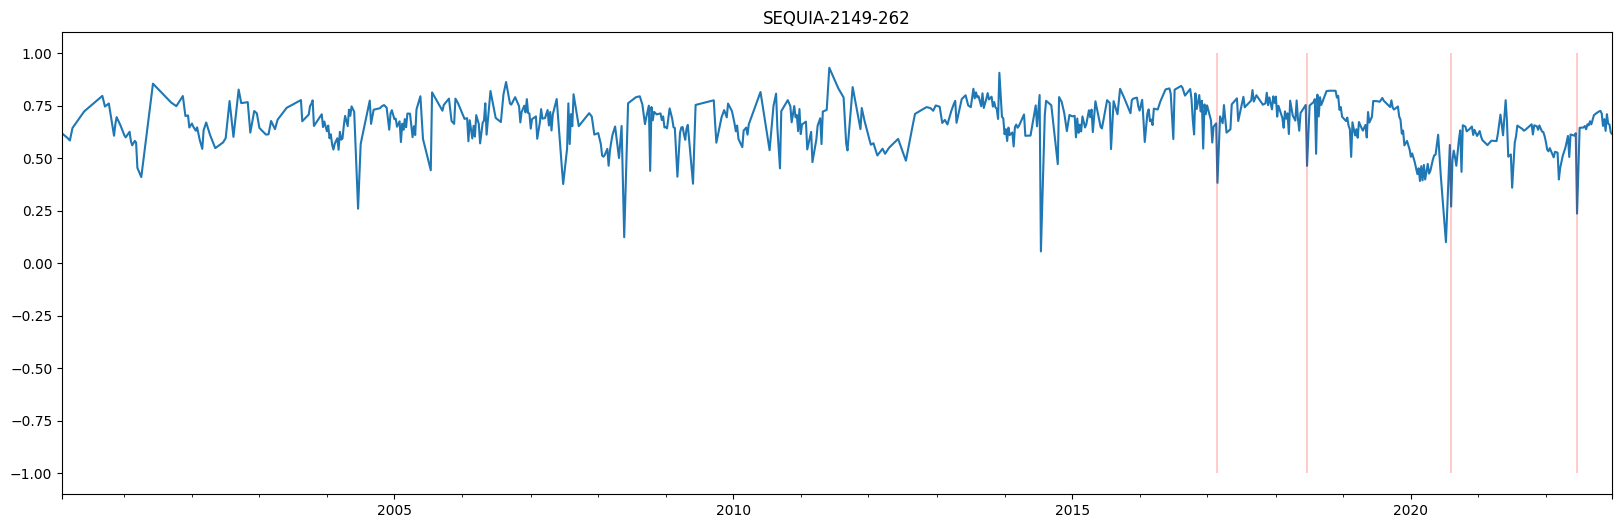

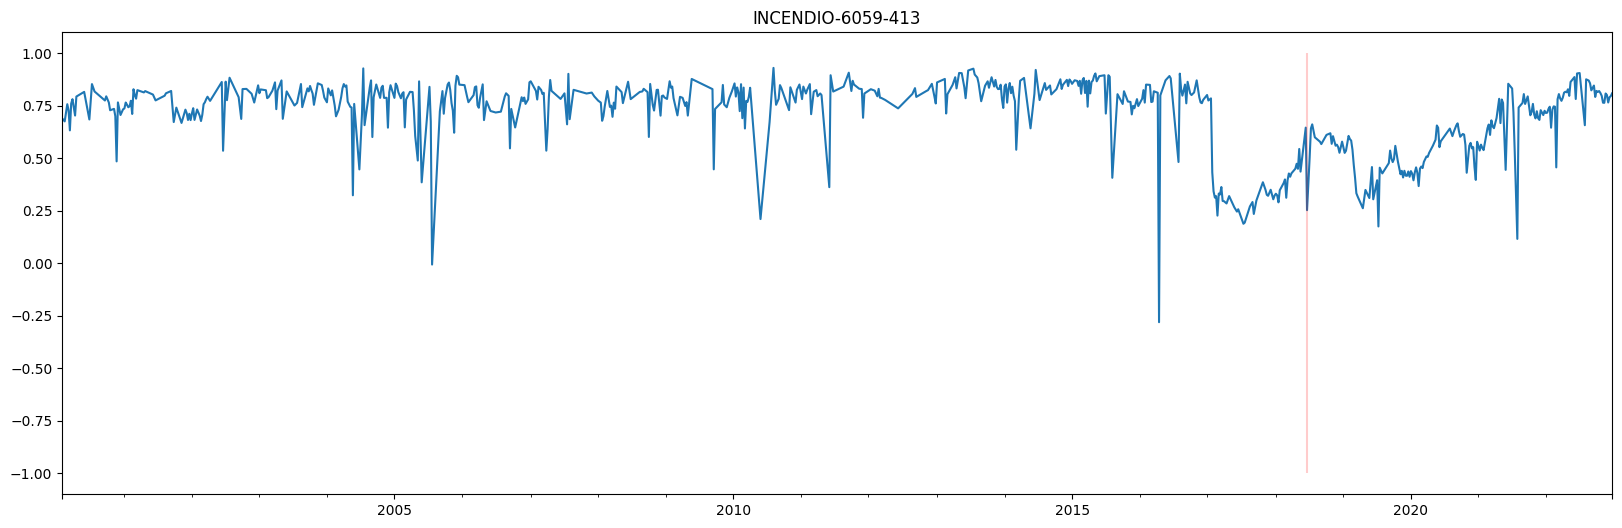

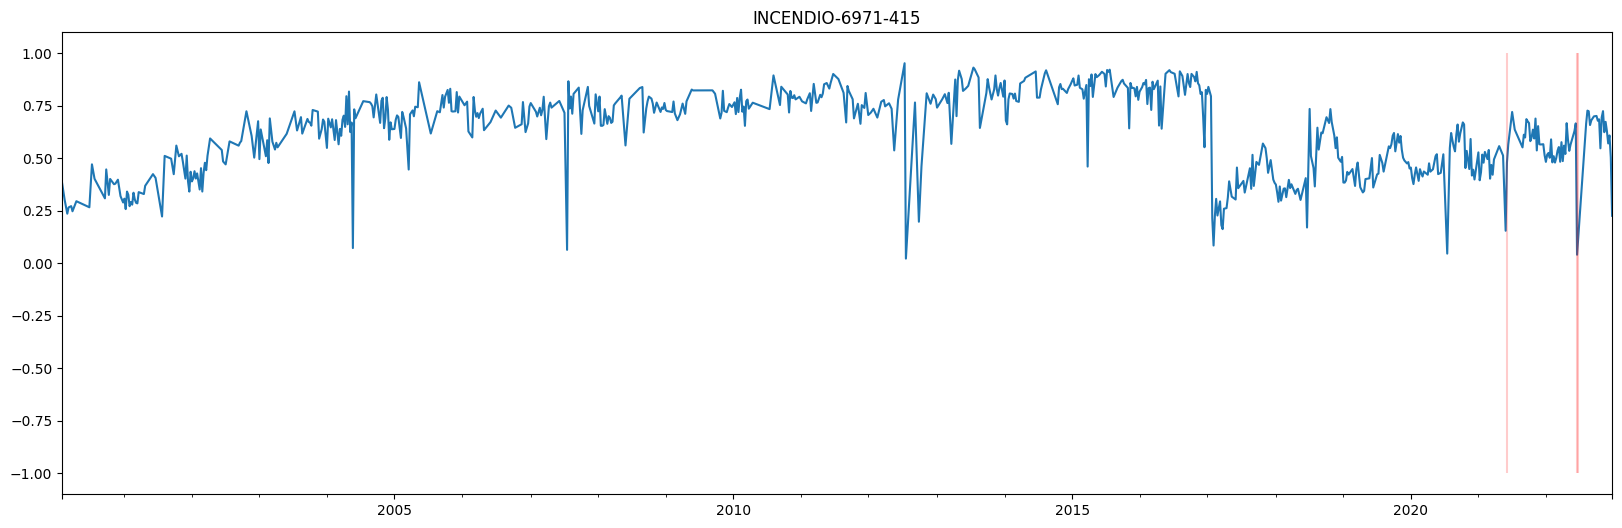

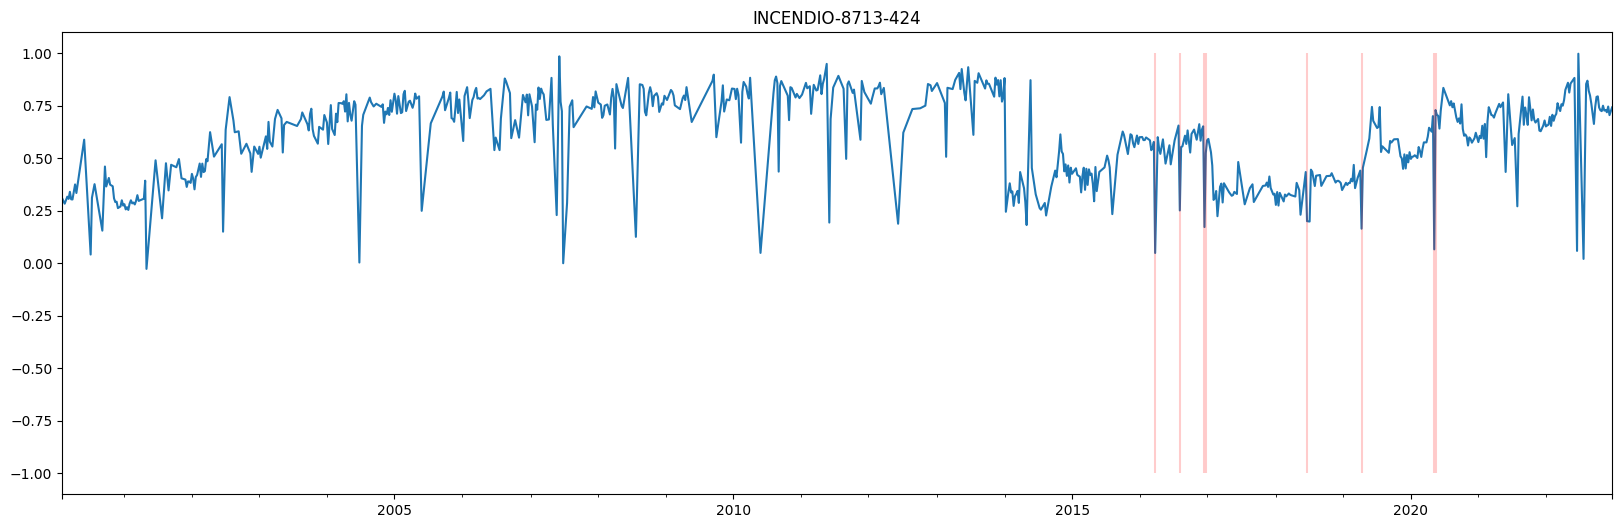

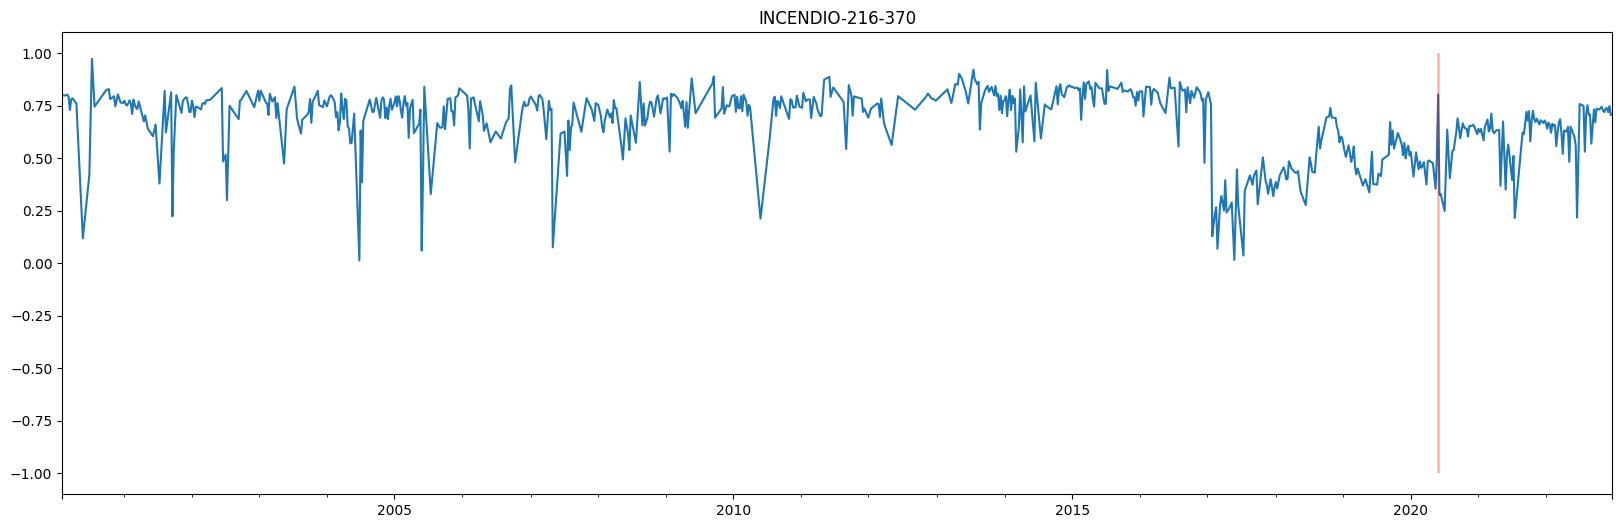

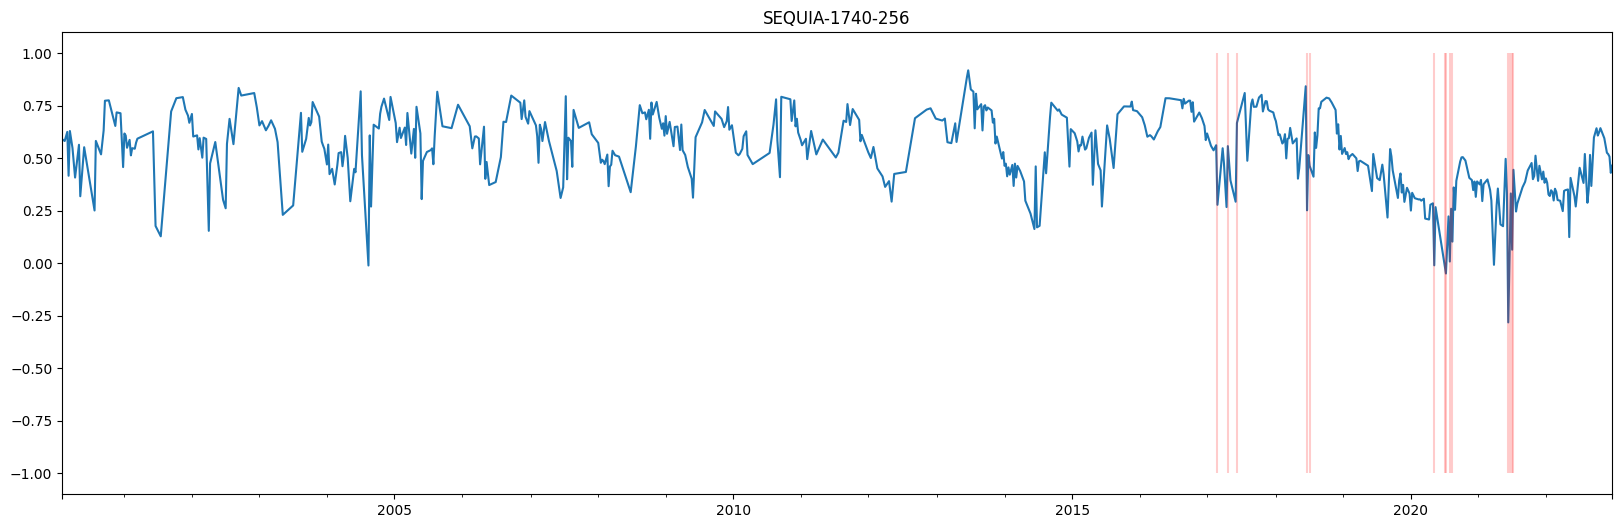

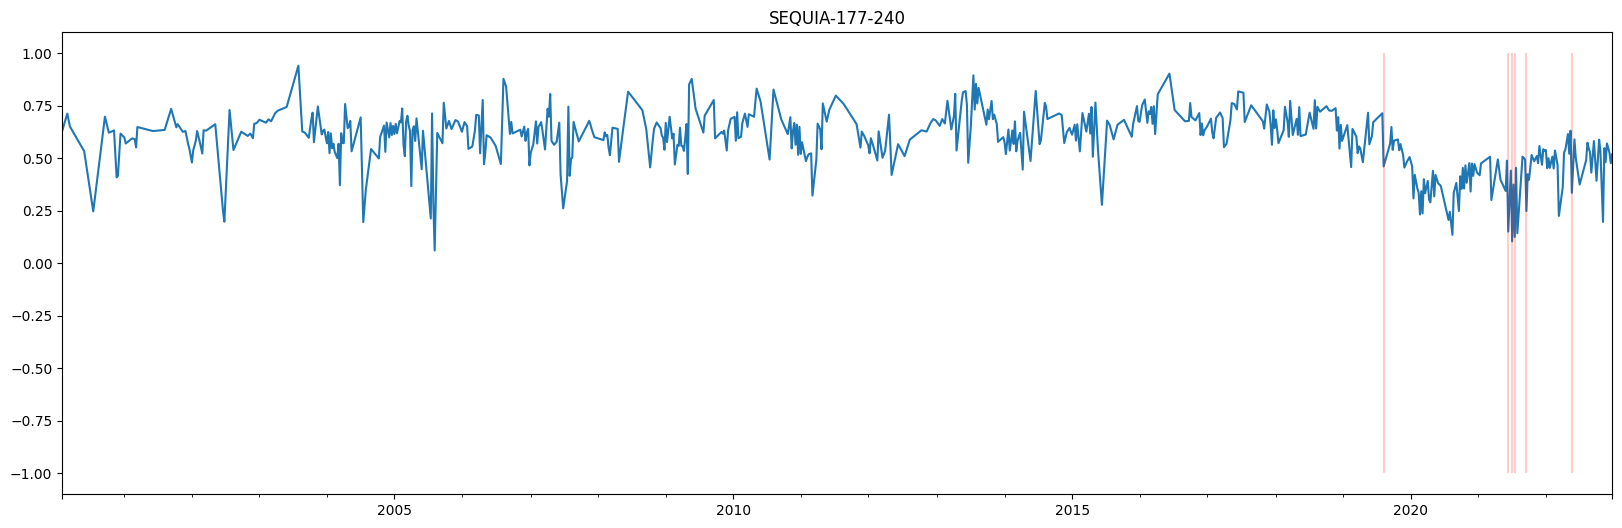

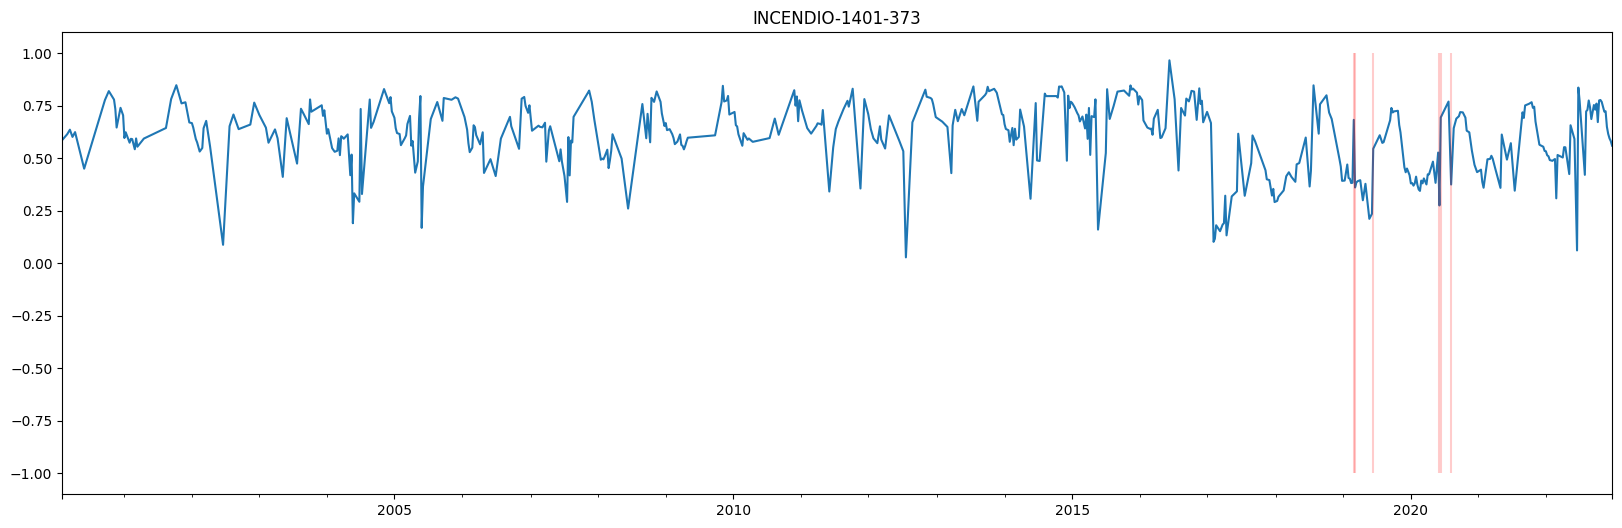

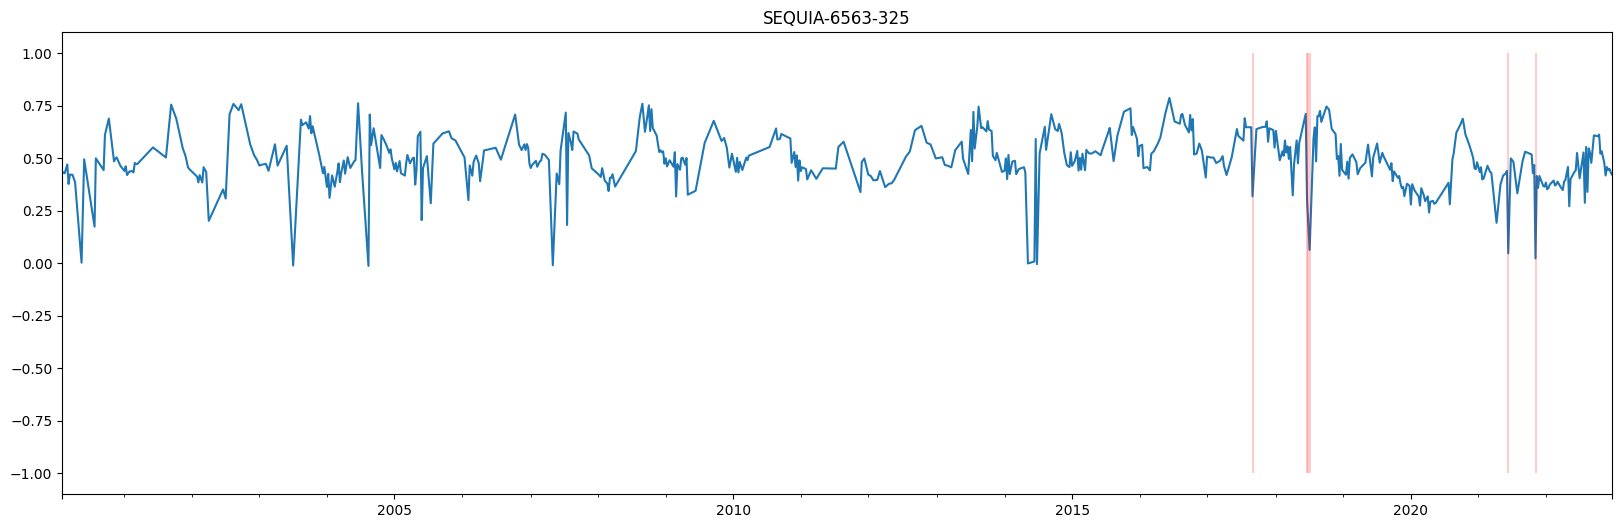

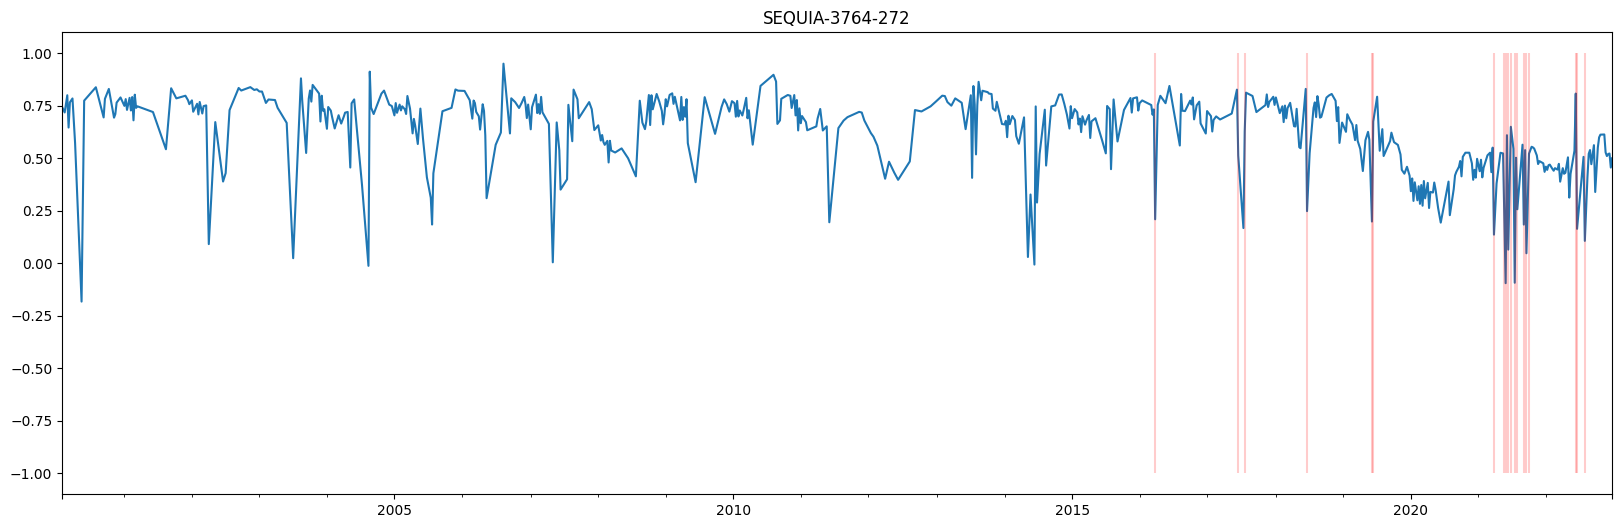

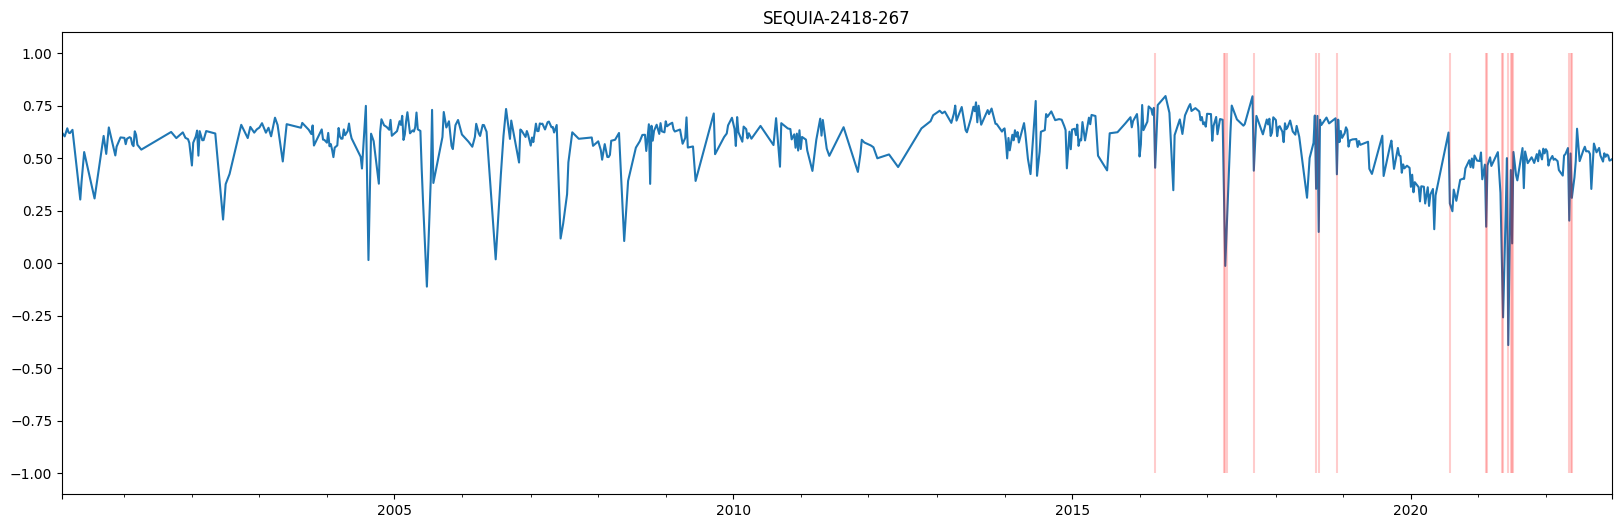

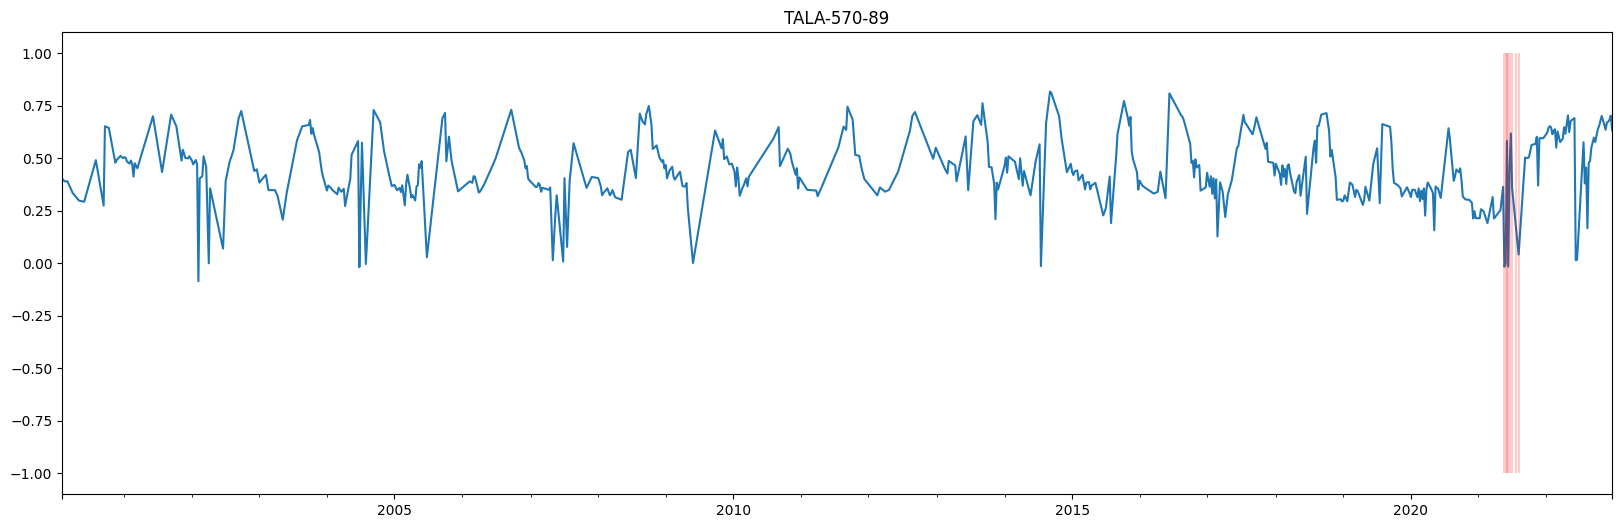

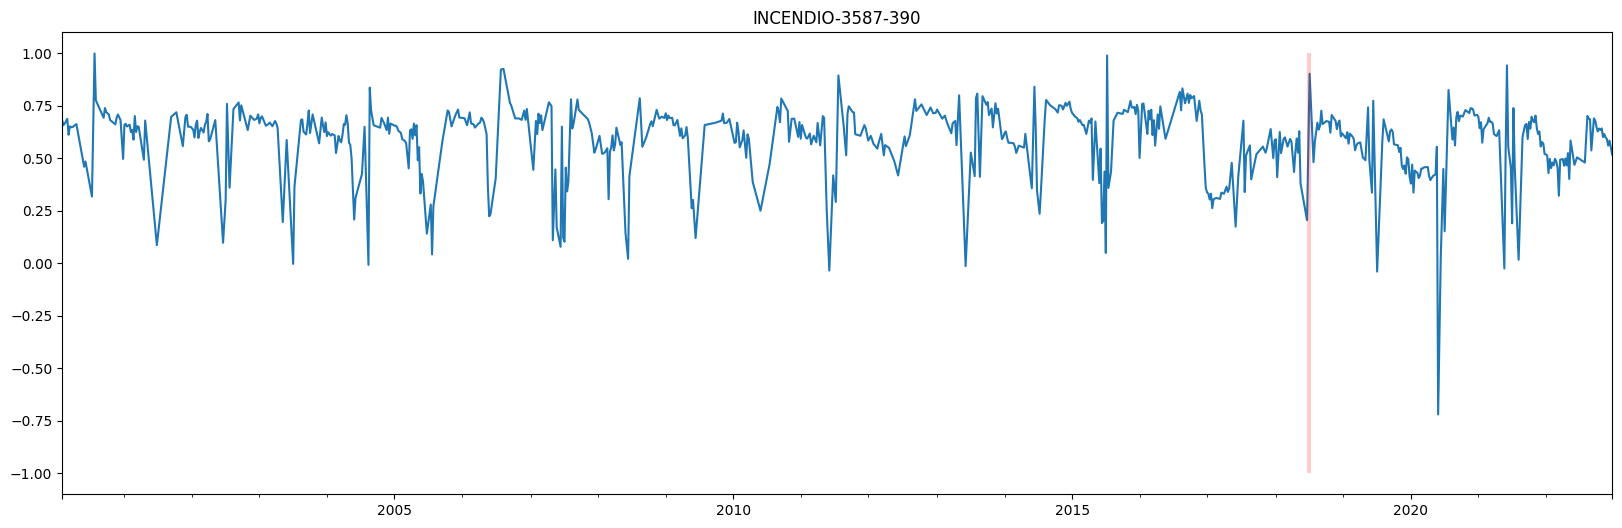

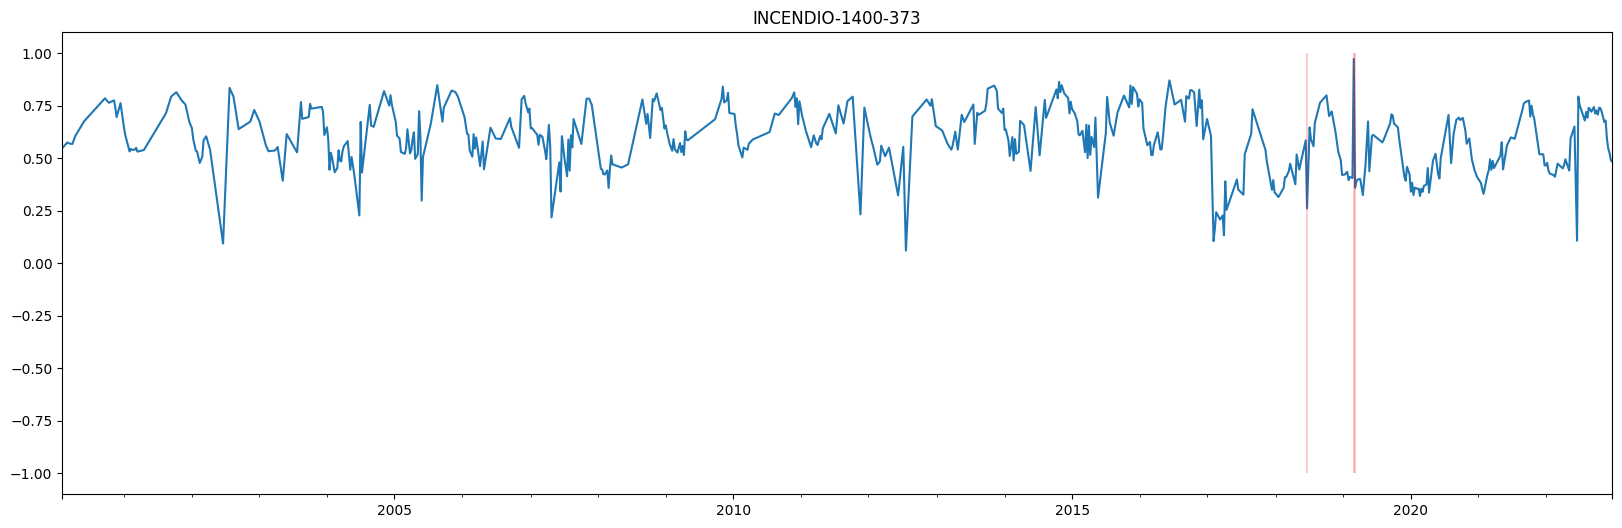

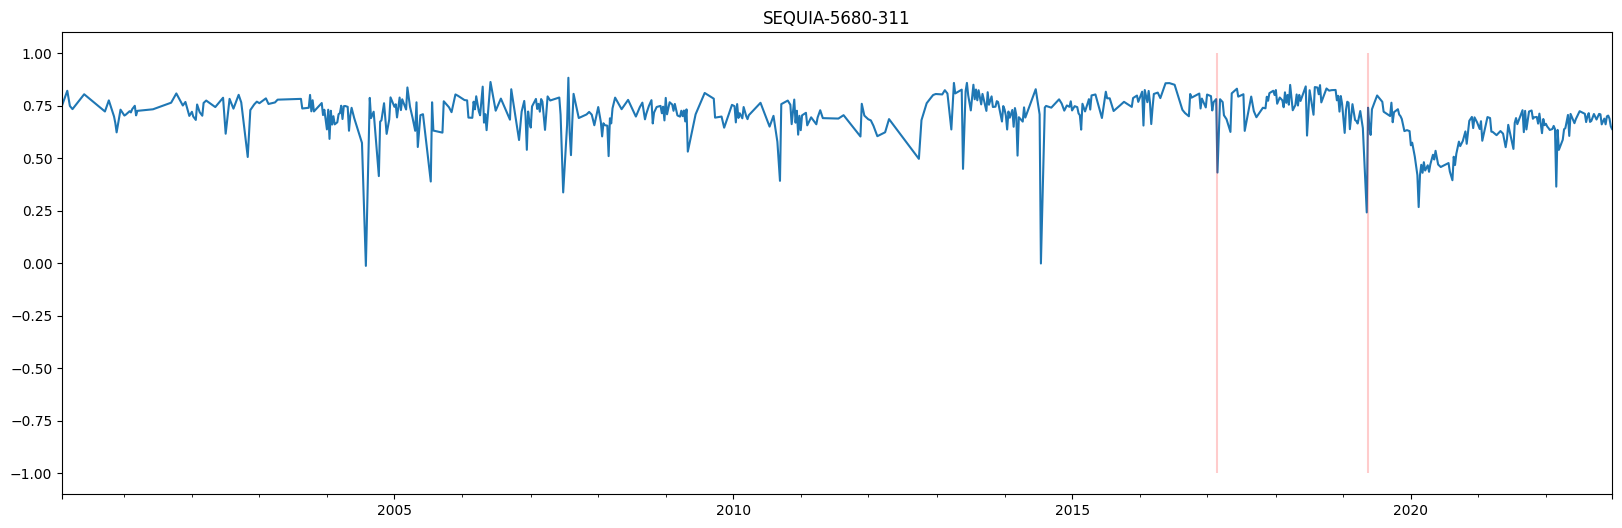

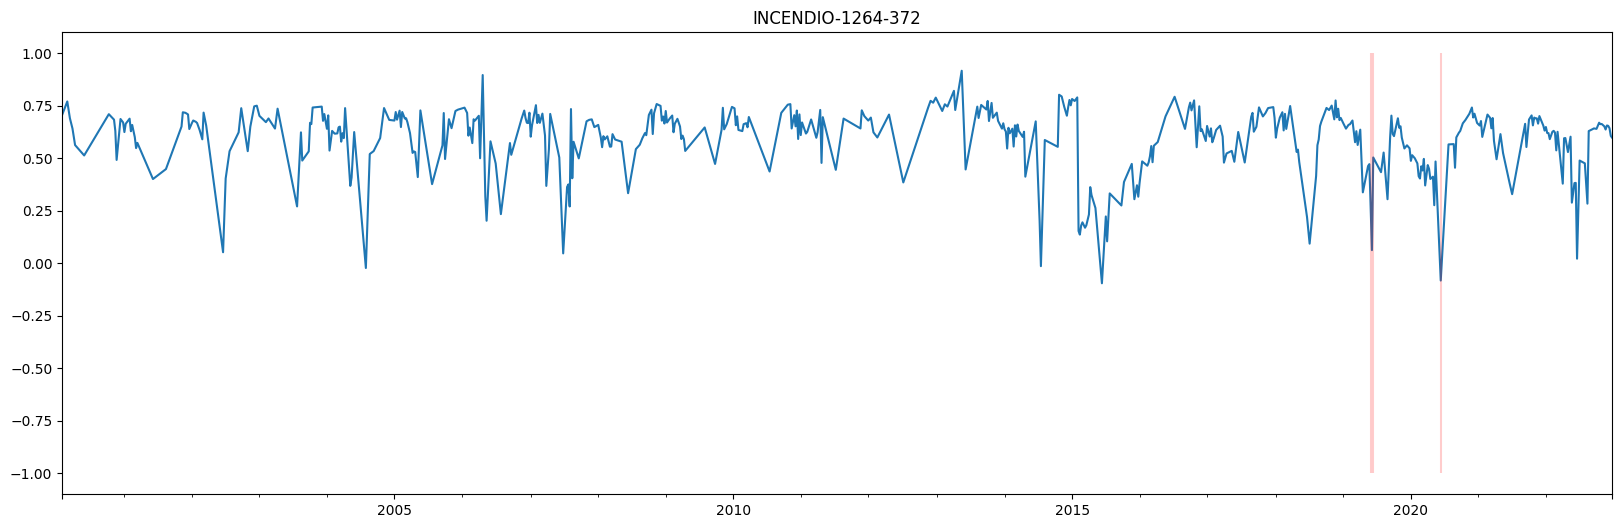

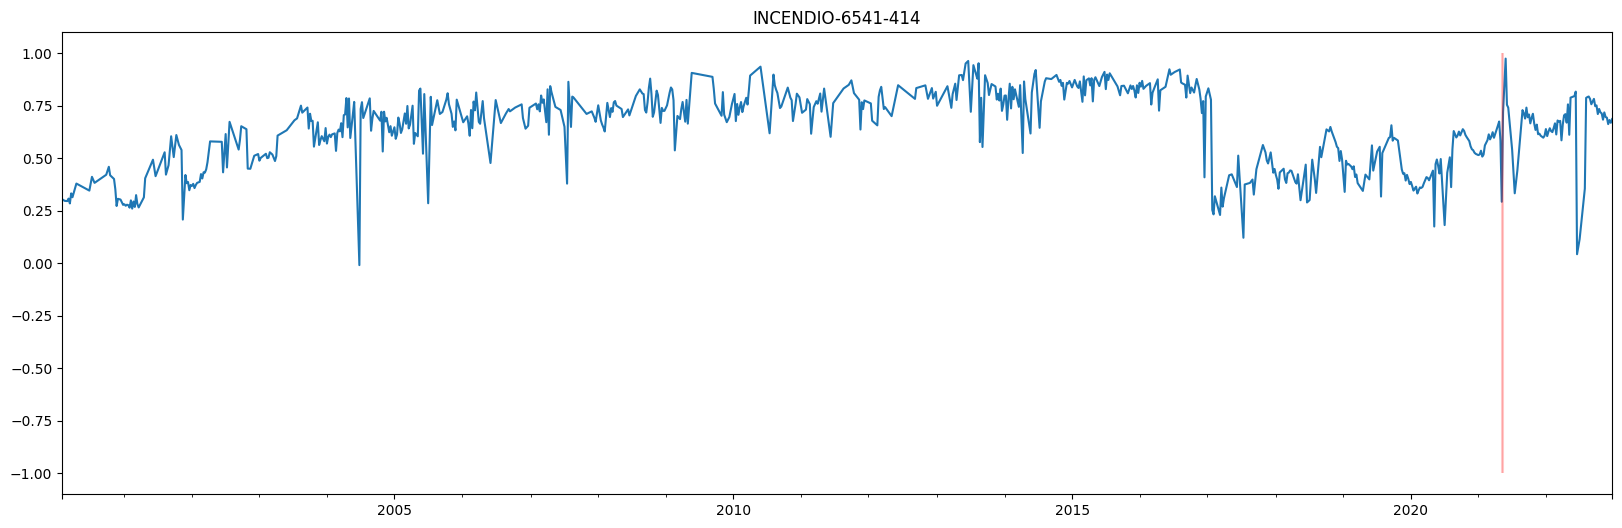

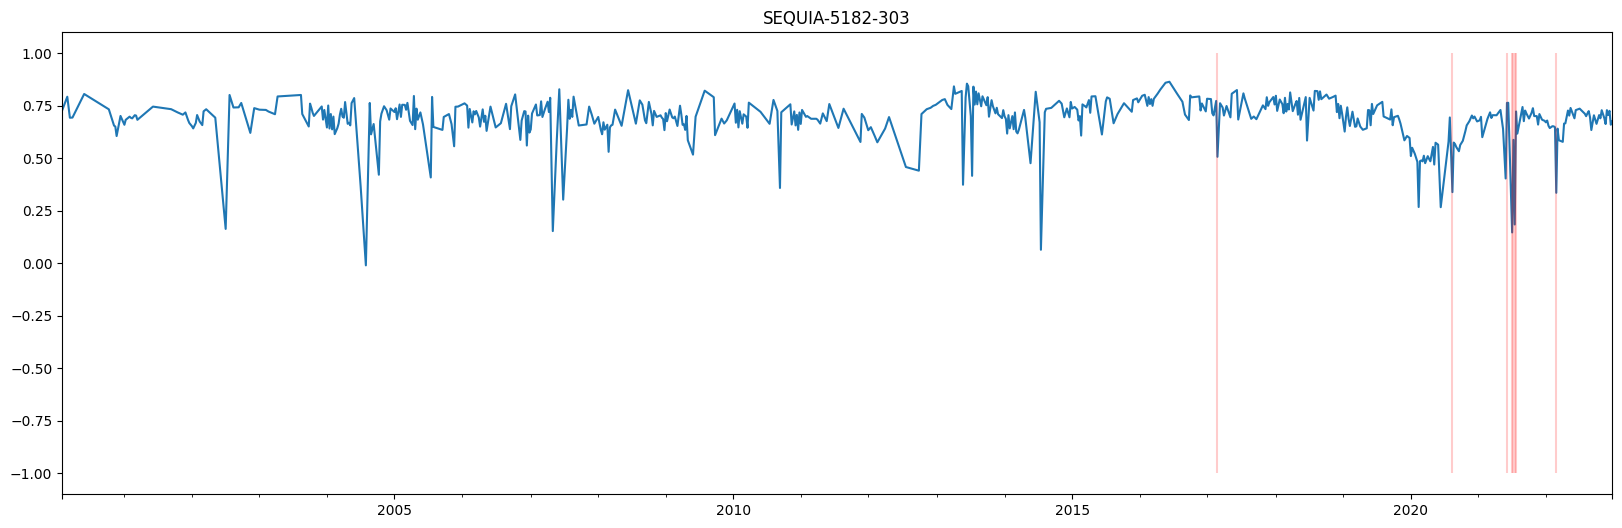

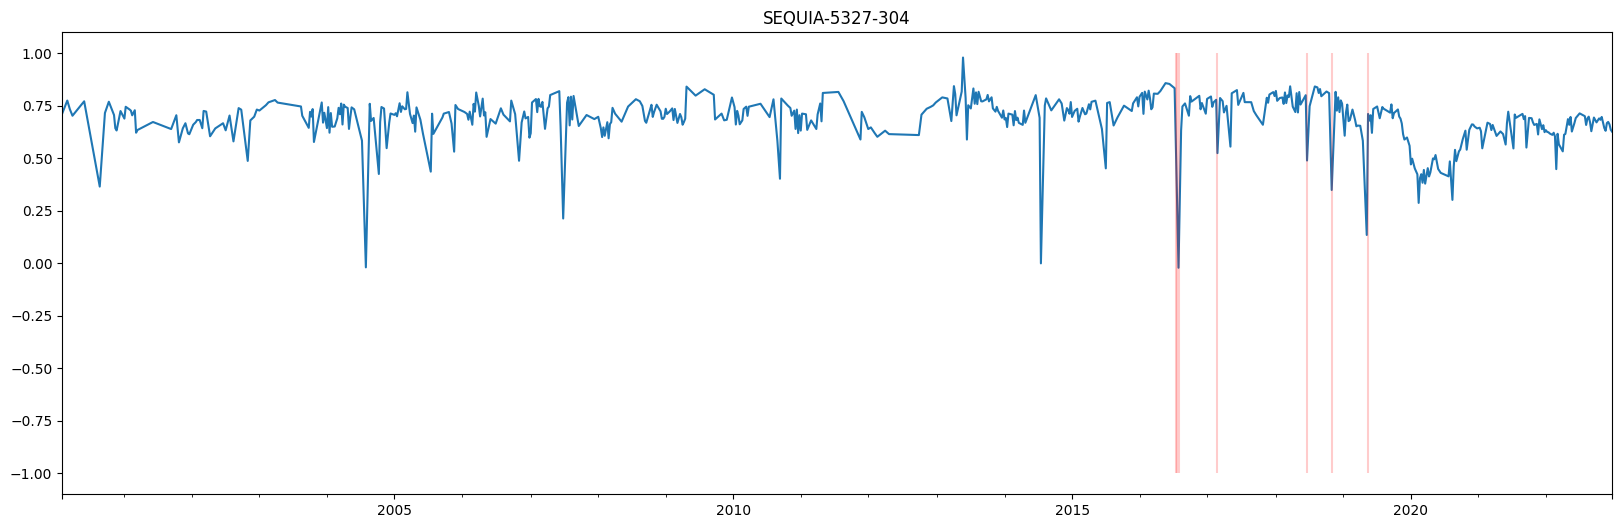

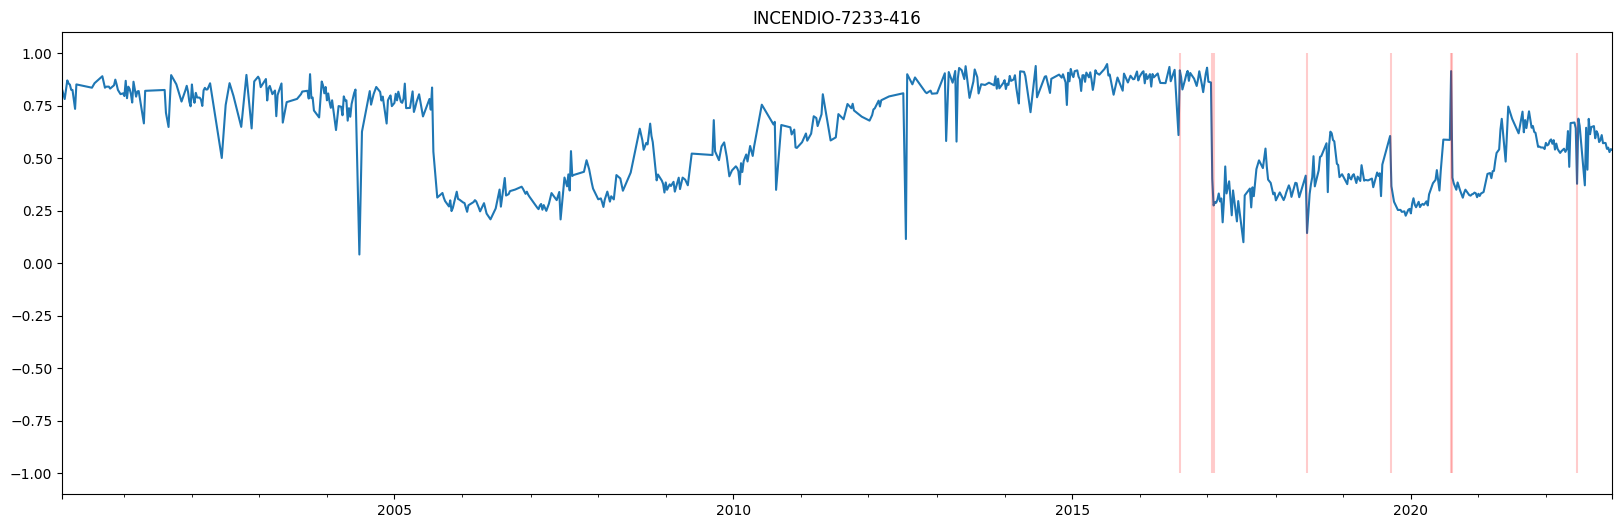

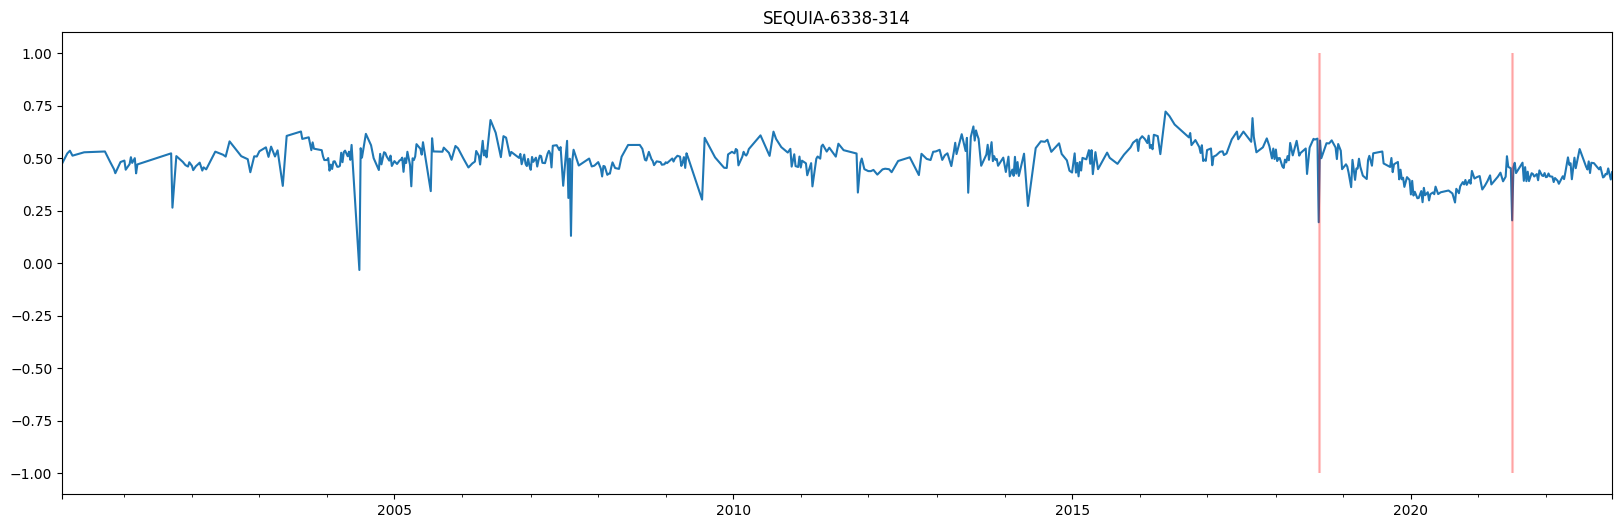

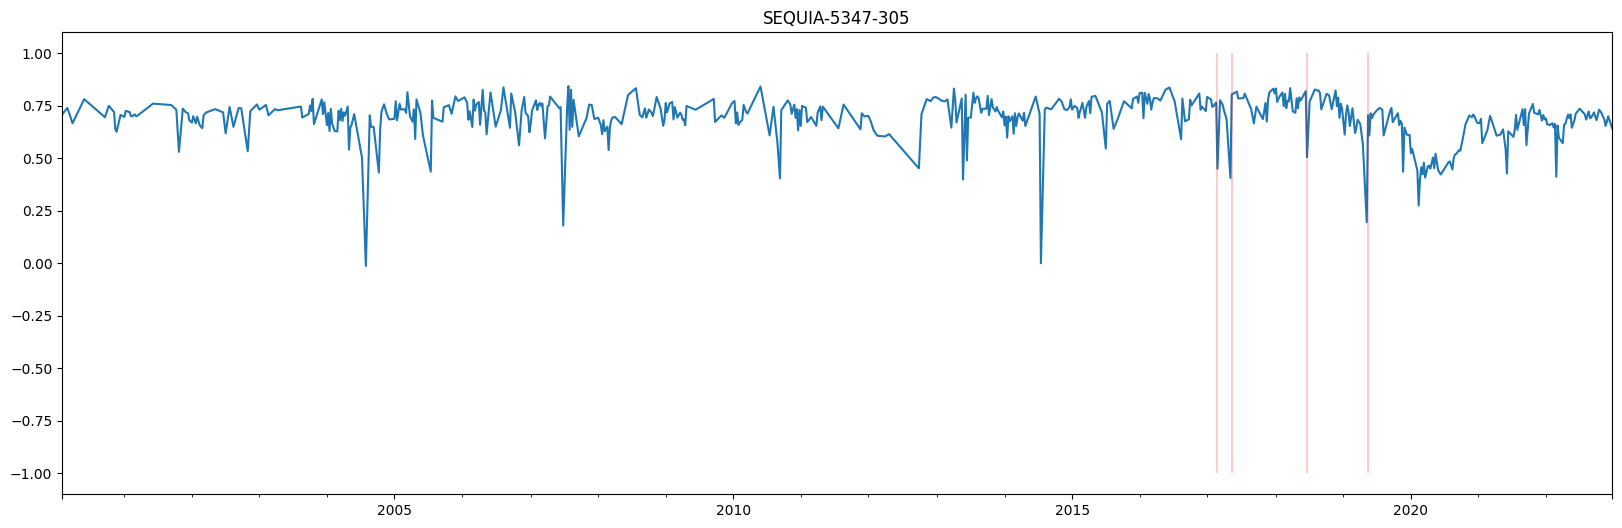

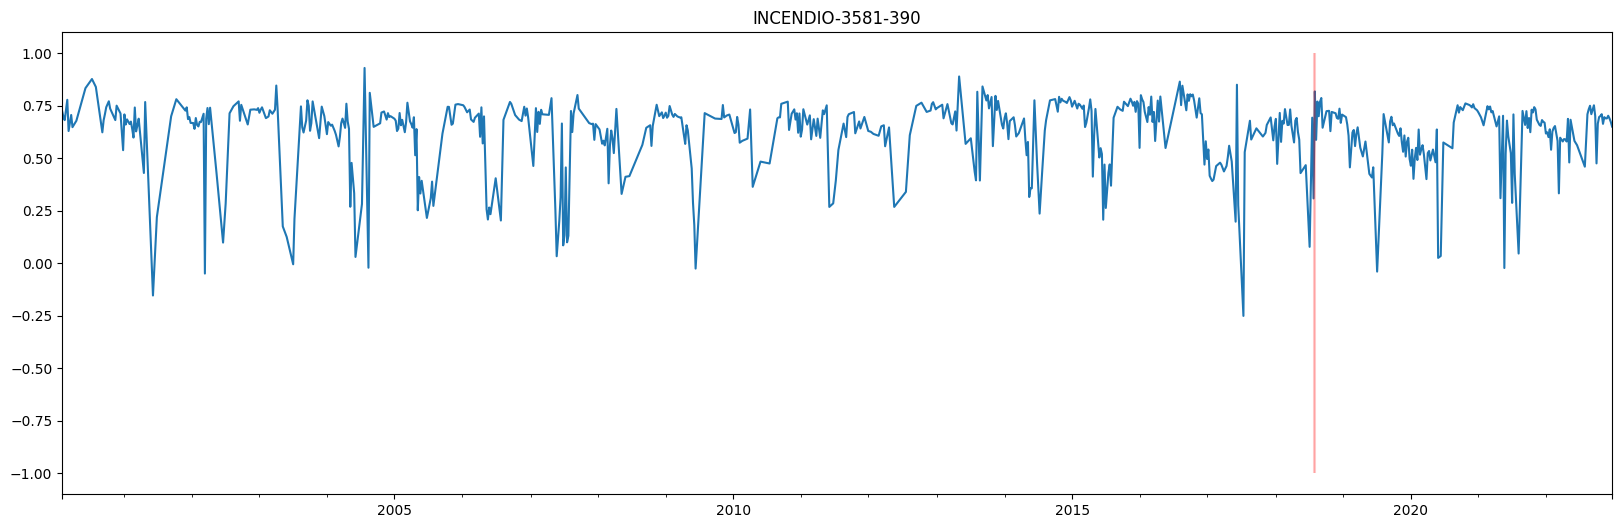

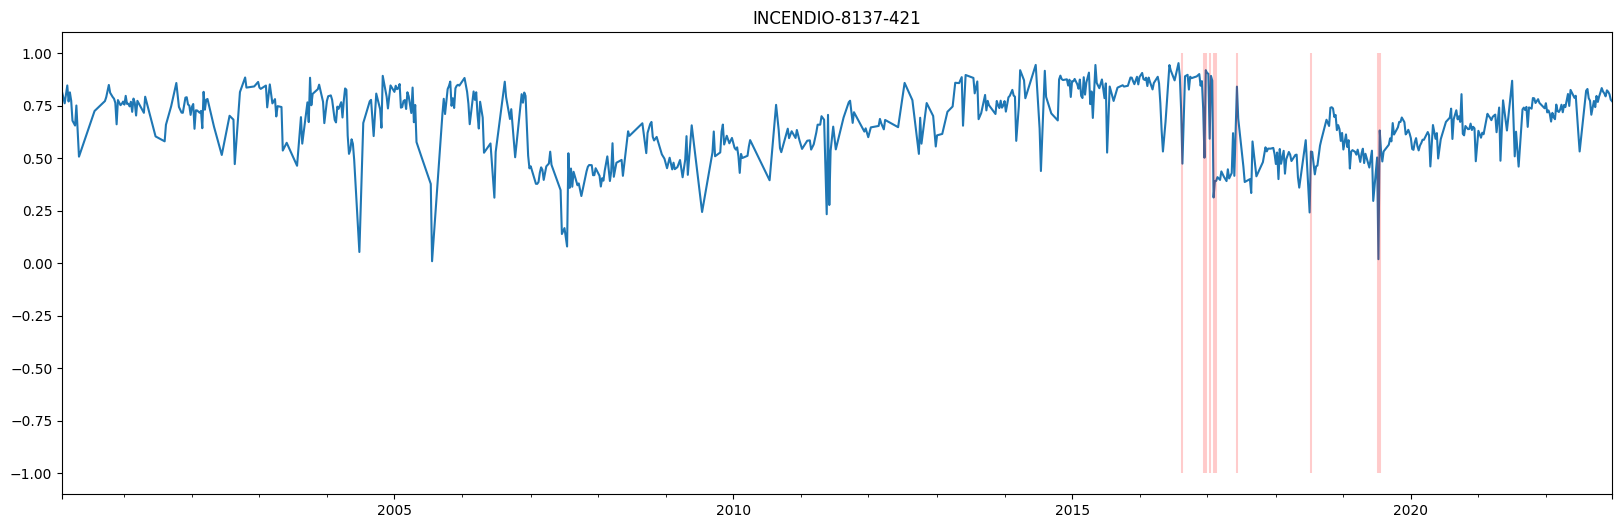

In [ ]:
VALUE = 30
correct_ts = correct_anomalies.target_indices.unique()


for ts_idx in np.random.choice(correct_ts, size=VALUE):
    show_pred_info(df_dict, anomalies_df, target_indices=ts_idx, is_right=True)

# Casos Particulares

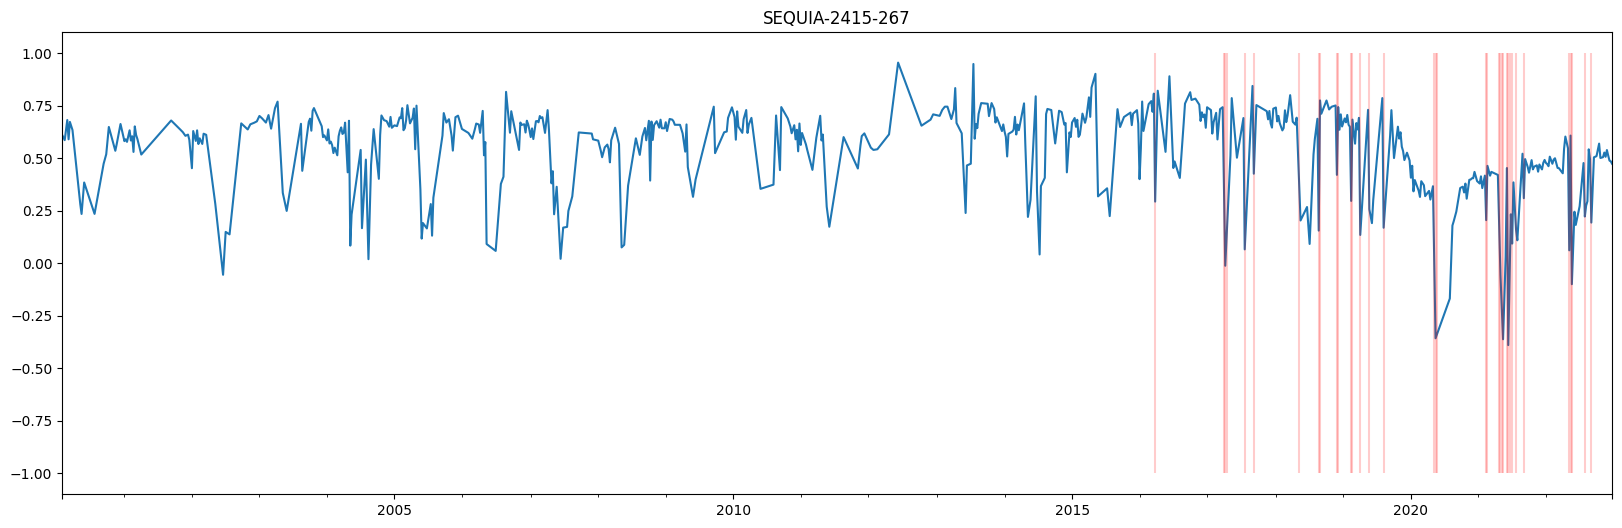

,target_indices,target_dates,NAME,IDpix,ID,Finicio,Ffinal,is_right,P_id
94392,SEQUIA-2415-267,2016-03-27,SEQUIA,2415,267,2006-02-27,2022-10-21,True,SEQUIA-267
99270,SEQUIA-2415-267,2017-04-02,SEQUIA,2415,267,2006-02-27,2022-10-21,True,SEQUIA-267
99425,SEQUIA-2415-267,2017-04-09,SEQUIA,2415,267,2006-02-27,2022-10-21,True,SEQUIA-267
99647,SEQUIA-2415-267,2017-04-16,SEQUIA,2415,267,2006-02-27,2022-10-21,True,SEQUIA-267
101657,SEQUIA-2415-267,2017-07-23,SEQUIA,2415,267,2006-02-27,2022-10-21,True,SEQUIA-267
102537,SEQUIA-2415-267,2017-09-10,SEQUIA,2415,267,2006-02-27,2022-10-21,True,SEQUIA-267
103775,SEQUIA-2415-267,2018-05-13,SEQUIA,2415,267,2006-02-27,2022-10-21,True,SEQUIA-267
108724,SEQUIA-2415-267,2018-08-26,SEQUIA,2415,267,2006-02-27,2022-10-21,True,SEQUIA-267
109045,SEQUIA-2415-267,2018-09-02,SEQUIA,2415,267,2006-02-27,2022-10-21,True,SEQUIA-267
109553,SEQUIA-2415-267,2018-12-02,SEQUIA,2415,267,2006-02-27,2022-10-21,True,SEQUIA-267


In [ ]:
show_pred_info(df_dict, anomalies_df, target_indices="SEQUIA-2415-267")

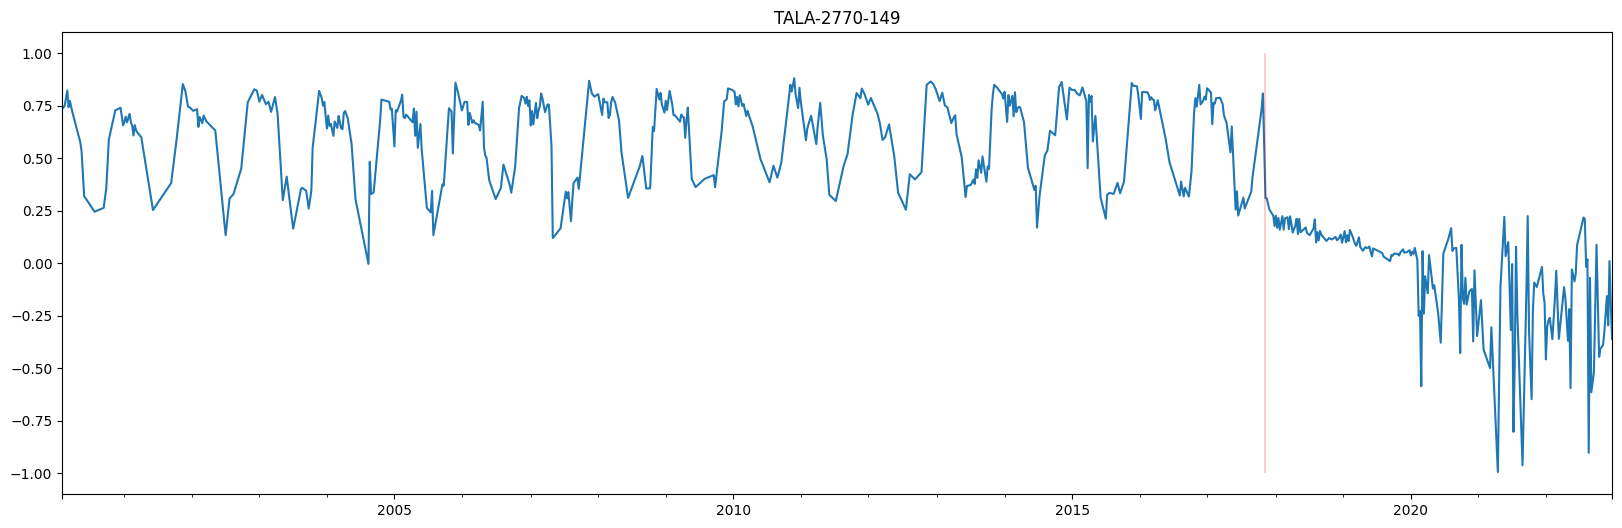

,target_indices,target_dates,NAME,IDpix,ID,Finicio,Ffinal,is_right,P_id
150344,TALA-2770-149,2017-11-12,TALA,2770,149,2017-08-13,2018-04-13,True,TALA-149


In [ ]:
show_pred_info(df_dict, anomalies_df, target_indices="TALA-2770-149", is_right=True)

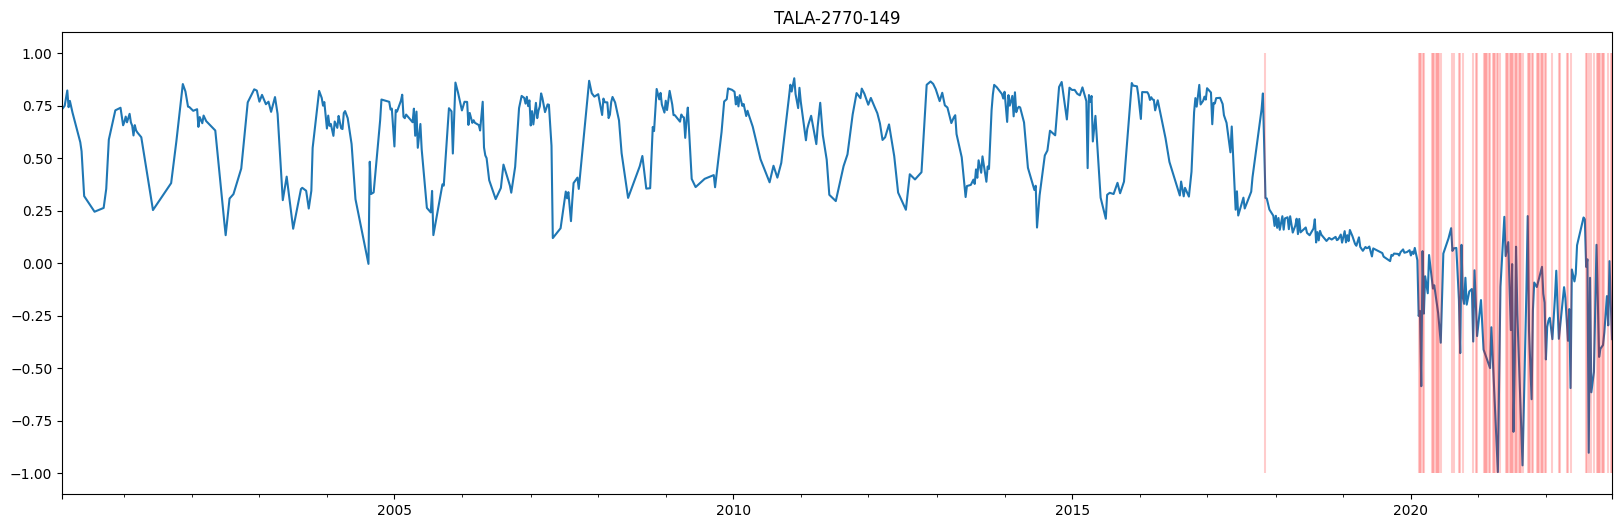

,target_indices,target_dates,NAME,IDpix,ID,Finicio,Ffinal,is_right,P_id
150344,TALA-2770-149,2017-11-12,TALA,2770,149,2017-08-13,2018-04-13,True,TALA-149
158118,TALA-2770-149,2020-02-16,TALA,2770,149,2017-08-13,2018-04-13,False,TALA-149
158136,TALA-2770-149,2020-02-23,TALA,2770,149,2017-08-13,2018-04-13,False,TALA-149
158209,TALA-2770-149,2020-03-01,TALA,2770,149,2017-08-13,2018-04-13,False,TALA-149
158253,TALA-2770-149,2020-03-08,TALA,2770,149,2017-08-13,2018-04-13,False,TALA-149
...,...,...,...,...,...,...,...,...,...
186411,TALA-2770-149,2022-11-06,TALA,2770,149,2017-08-13,2018-04-13,False,TALA-149
186453,TALA-2770-149,2022-11-13,TALA,2770,149,2017-08-13,2018-04-13,False,TALA-149
186547,TALA-2770-149,2022-12-04,TALA,2770,149,2017-08-13,2018-04-13,False,TALA-149
186567,TALA-2770-149,2022-12-18,TALA,2770,149,2017-08-13,2018-04-13,False,TALA-149


In [ ]:
show_pred_info(df_dict, anomalies_df, target_indices="TALA-2770-149", is_right=False)

* Mostrar series de buenos ejemplos y malos ejemplos. 
* Métricas corregidas... 
    * Calcular los FN, FP, TP, TN... 
* Mostrar Polígono, Serie de tiempo de un pixel, Poligono total con anomalías pintadas...

